In [1]:
import numpy as np

class Kernel:
    def f(self, x1, x2):
        raise NotImplementedError()
    def f_mat(self, x):
        raise NotImplementedError()

class WhiteNoise(Kernel):
    def __init__(self, scale):
        self.scale = scale
    def f(self, x1, x2):
        return self.scale * (x1 == x2)
    def f_mat(self, x):
        return self.scale * np.eye(len(x))

class Constant(Kernel):
    def __init__(self, value):
        self.value = value
    def f(self, x1, x2):
        return self.value
    def f_mat(self, x):
        n = len(x)
        return self.value * np.ones((n, n))

class Linear(Kernel):
    def __init__(self, intercept):
        self.intercept = intercept
    def f(self, x1, x2):
        return (x1 - self.intercept) * (x2 - self.intercept)
    def f_mat(self, x):
        xs_minus_intercept = np.asarray(x) - self.intercept
        return np.outer(xs_minus_intercept, xs_minus_intercept)

class SquaredExponential(Kernel):
    def __init__(self, scale):
        self.scale = scale
    def f(self, x1, x2):
        return np.exp(-.5 * (x1 - x2) * (x1 - x2) / self.scale)
    def f_mat(self, x):
        dx = np.subtract.outer(x, x)
        return np.exp(-0.5 * dx * dx / self.scale)

class Periodic(Kernel):
    def __init__(self, scale, period):
        self.scale = scale
        self.period = period
    def f(self, x1, x2):
        freq = 2 * np.pi / self.period
        return np.exp((-1. / self.scale) * (np.sin(freq * abs(x1 - x2)))**2)
    def f_mat(self, x):
        freq = 2 * np.pi / self.period
        dx = np.subtract.outer(x, x)
        return np.exp((-1. / self.scale) * (np.sin(freq * abs(dx)))**2)

class Plus(Kernel):
    def __init__(self, K, H):
        self.K = K
        self.H = H
    def f(self, x1, x2):
        return self.K.f(x1, x2) + self.H.f(x1, x2)
    def f_mat(self, x):
        return self.K.f_mat(x) + self.H.f_mat(x)

class Times(Kernel):
    def __init__(self, K, H):
        self.K = K
        self.H = H
    def f(self, x1, x2):
        return self.K.f(x1, x2) * self.H.f(x1, x2)
    def f_mat(self, x):
        return self.K.f_mat(x) * self.H.f_mat(x)

def sigma_cp(x, location, scale):
    return .5 * (1 + np.tanh((location - x) / scale))

class ChangePoint(Kernel):
    def __init__(self, K, H, location, scale):
        self.K = K
        self.H = H
        self.location = location
        self.scale = scale
    def f(self, x1, x2):
        sigma_x1 = sigma_cp(x1, self.location, self.scale)
        sigma_x2 = sigma_cp(x2, self.location, self.scale)
        cov_K = sigma_x1 * self.K.f(x1, x2) * sigma_x2
        cov_H = (1 - sigma_x1) * self.H.f(x1, x2) * (1 - sigma_x2)
        return cov_K + cov_H
    def f_mat(self, x):
        change_x = sigma_cp(x, self.location, self.scale)
        sig_1 = np.outer(change_x, change_x)
        sig_2 = np.outer(1 - change_x, 1 - change_x)
        cov_K = self.K.f_mat(x)
        cov_H = self.H.f_mat(x)
        return sig_1 * cov_K + sig_2 * cov_H

In [2]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [3]:
xs = np.linspace(0, 10, 500)

0 0.032848654169630266
1 0.09295683973305144
2 0.018798416184094342
3 0.09527951453249915
4 0.1369681436494184
5 0.054827823064513
6 0.023163147288538327
7 0.02913125625777299
8 0.05946402693066645
9 0.09651503431427677
10 0.011041250472891884
11 0.23577481268489814
12 0.19592562177659448
13 0.09493793223657204
14 0.08531447809082174
15 0.005043835543698591
16 0.0735108386556352
17 0.2473447838785629
18 0.07320159313174693
19 0.42902502918451585


<ipython-input-4-6153120c98a3>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


0 ['0.99', '0.90', '-1.85', '-1.83']
1 ['-0.05', '0.15', '-1.90', '-1.88']
2 ['-1.10', '-1.06', '-0.13', '-0.14']
3 ['-0.74', '-0.72', '-1.38', '-1.28']
4 ['-0.89', '-1.13', '0.60', '0.65']
5 ['1.92', '2.07', '0.67', '0.70']
6 ['0.11', '0.15', '0.06', '0.11']
7 ['-0.54', '-0.51', '0.72', '0.73']
8 ['-1.09', '-0.97', '1.13', '0.98']
9 ['-0.04', '-0.14', '0.93', '0.93']
10 ['-0.72', '-0.68', '0.41', '0.37']
11 ['-0.79', '-0.37', '-1.10', '-1.15']
12 ['0.40', '0.33', '0.35', '0.13']
13 ['-0.55', '-0.39', '0.52', '0.57']
14 ['0.82', '0.68', '0.10', '0.12']
15 ['-1.19', '-1.21', '-0.73', '-0.74']
16 ['-1.54', '-1.51', '-0.13', '-0.14']
17 ['1.78', '2.06', '-2.37', '-2.30']
18 ['0.20', '0.18', '1.91', '1.99']
19 ['1.50', '1.89', '0.33', '1.44']


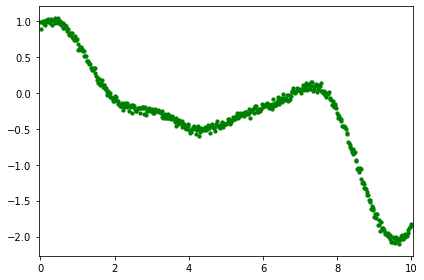

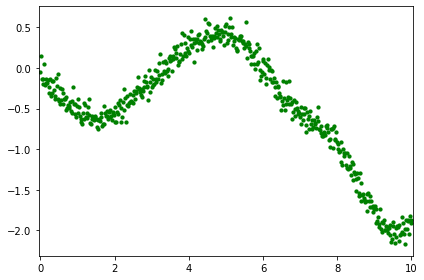

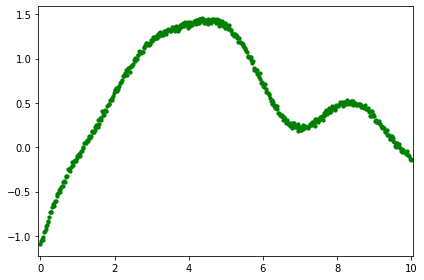

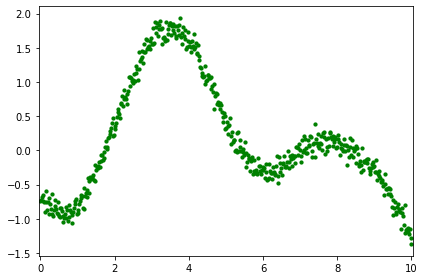

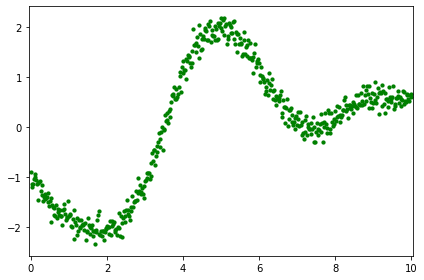

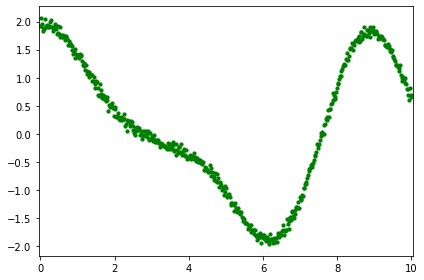

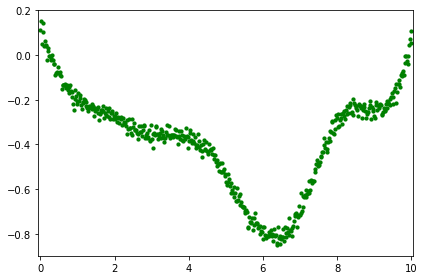

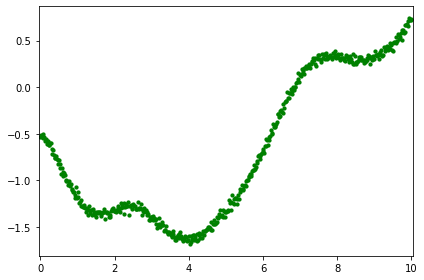

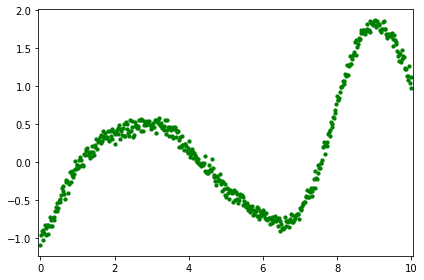

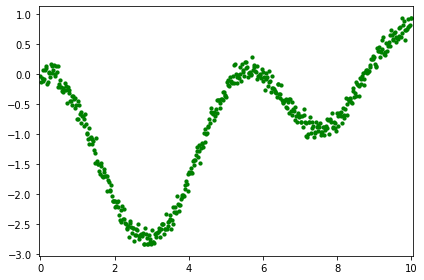

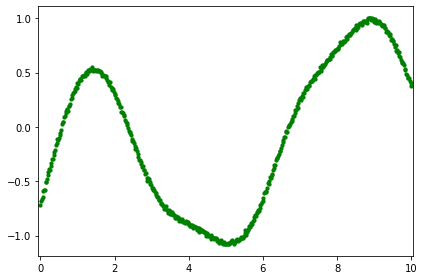

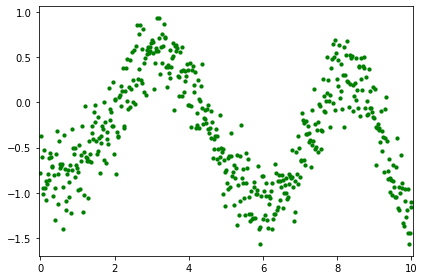

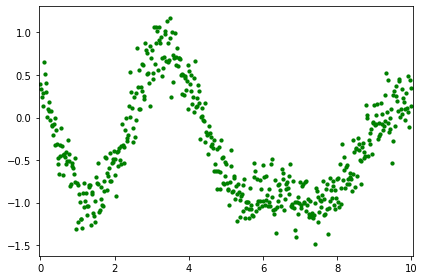

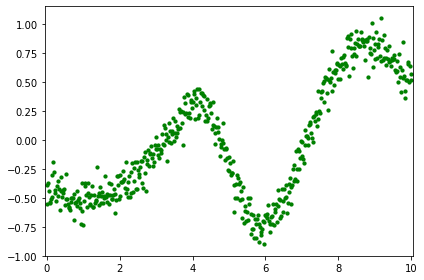

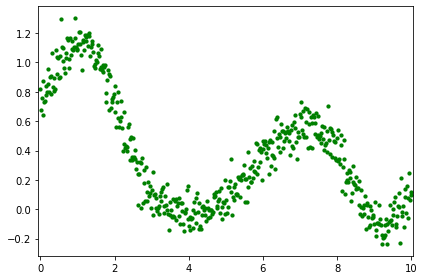

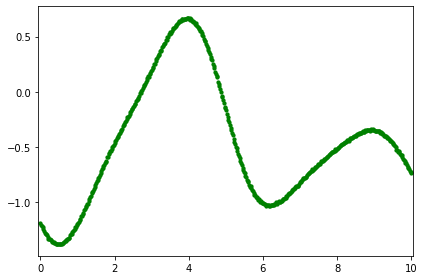

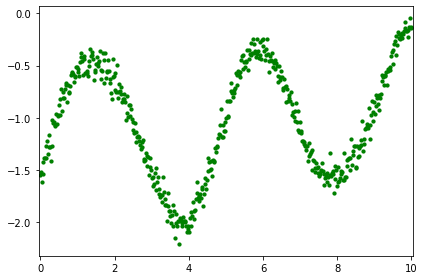

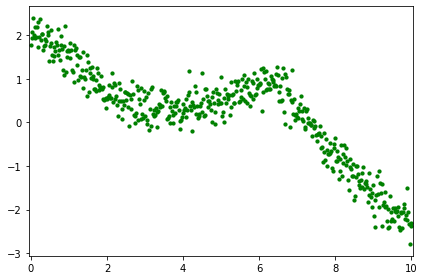

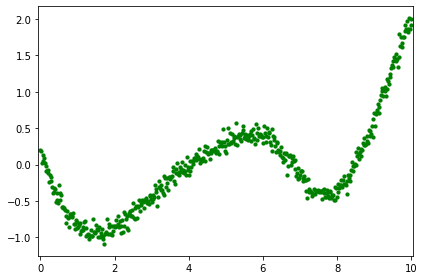

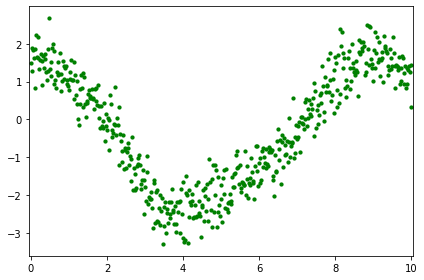

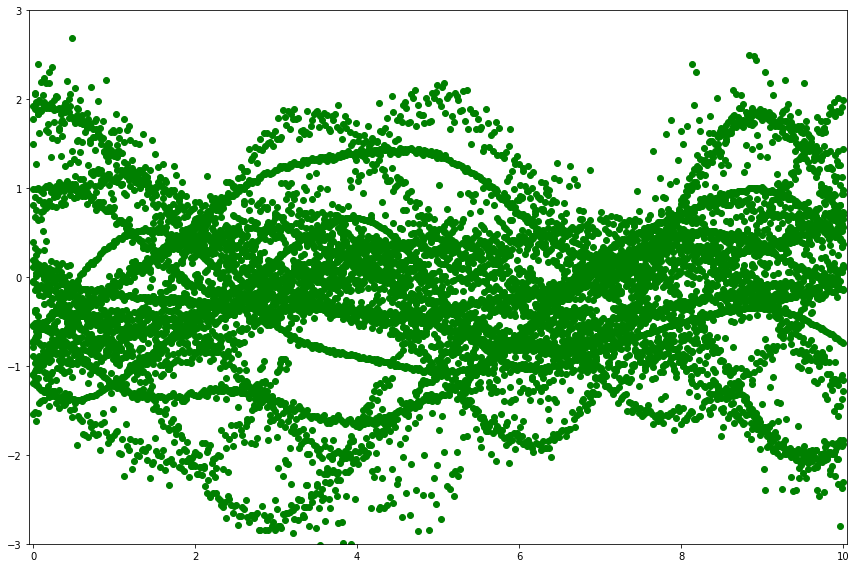

In [4]:
cov = SquaredExponential(2)
M = cov.f_mat(xs)
N = 6
ys_list = []

np.random.seed(12)
for i in range(20):
    fig, ax = plt.subplots()
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    prefactor = 0.2 if i < 10 else 0.6
    epsilon = np.random.uniform(0, prefactor*abs(.2*(max(ys) - min(ys))))
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(6,4)
    fig.set_tight_layout(True)
    figname = '/tmp/gp-se-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    print(i, epsilon)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.scatter(xs, ys, color='green', linewidth=1)
    ax.set_xlim([-.05, 10.05])
    ax.set_ylim([-3, 3])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
    fig.set_tight_layout(True)
figname = '/tmp/gp-se.png'
fig.savefig(figname, dpi=200)

for i, ys in enumerate(ys_list):
    print(i, ['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])

<ipython-input-5-6236a0a5ec10>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


['-0.15', '-0.12', '13.46', '13.63']
['-0.76', '0.30', '13.68', '13.81']
['-0.20', '-0.16', '20.20', '20.18']
['-0.15', '-0.20', '20.05', '19.97']
['0.03', '0.03', '0.70', '0.64']
['0.18', '0.05', '0.68', '0.50']
['-0.16', '-0.13', '11.12', '11.21']
['0.21', '0.33', '11.30', '10.87']
['0.05', '0.04', '-7.75', '-7.81']
['-0.38', '0.07', '-7.75', '-7.97']
['-0.07', '-0.05', '5.53', '5.53']
['-0.14', '-0.08', '5.68', '5.71']
['-0.08', '-0.06', '4.59', '4.65']
['-0.15', '-0.05', '4.53', '4.68']
['0.06', '0.05', '-2.13', '-2.20']
['-0.07', '-0.04', '-1.81', '-2.13']
['-0.01', '-0.01', '1.14', '0.91']
['-0.04', '0.11', '1.45', '0.72']
['-0.11', '-0.09', '11.09', '11.08']
['-0.20', '-0.13', '11.02', '11.12']
['-0.16', '-0.13', '15.59', '15.77']
['-0.20', '0.08', '15.59', '15.97']
['-0.02', '-0.02', '1.46', '1.42']
['-0.02', '-0.01', '1.47', '1.42']
['-0.04', '-0.03', '4.33', '4.21']
['0.00', '-0.06', '4.41', '4.26']
['0.02', '0.02', '-1.25', '-1.29']
['-0.06', '-0.01', '-1.20', '-1.35']
['0.0

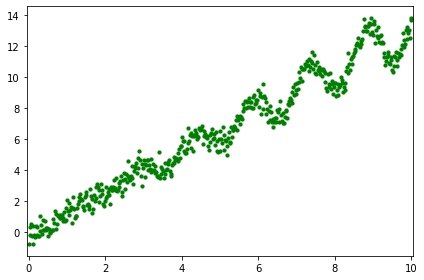

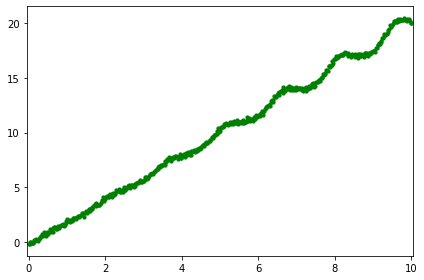

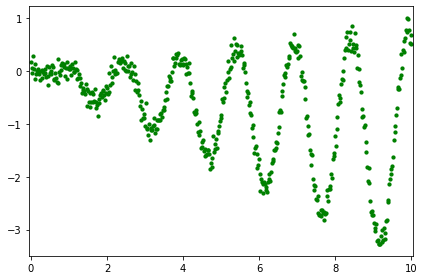

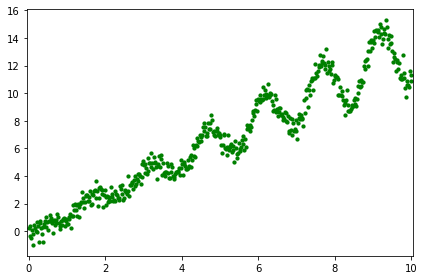

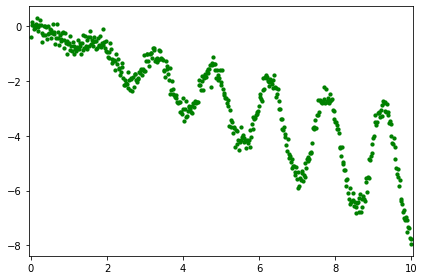

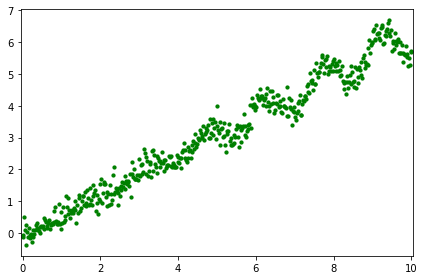

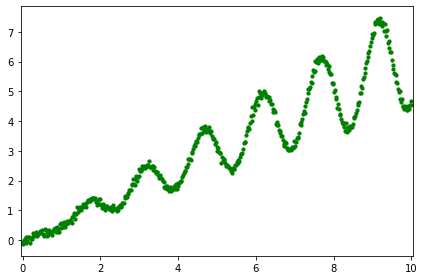

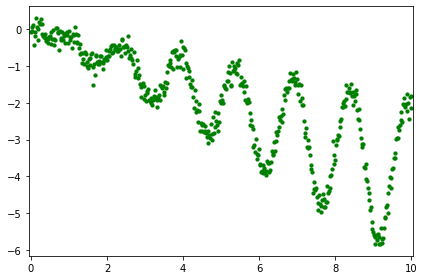

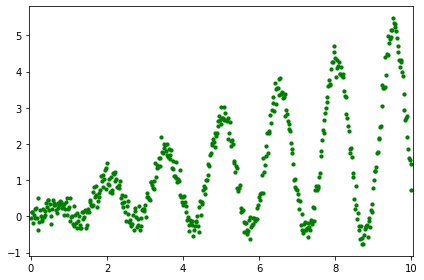

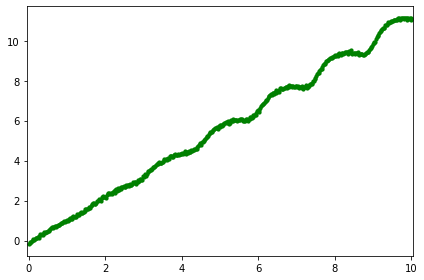

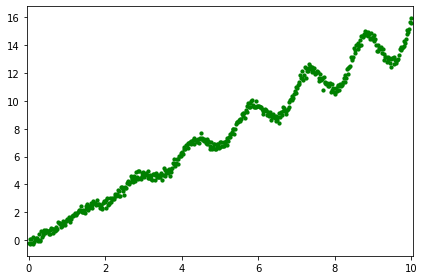

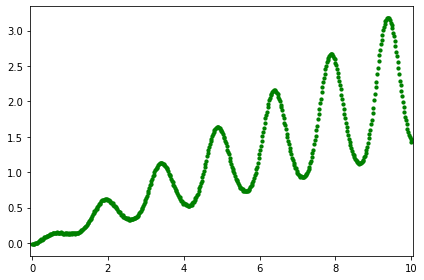

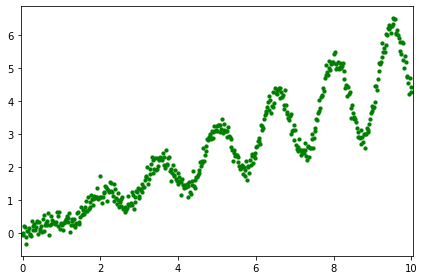

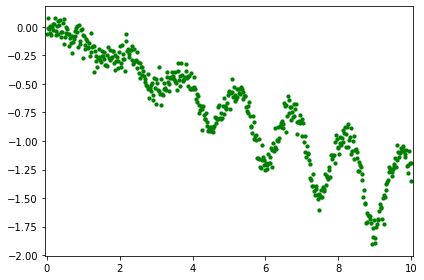

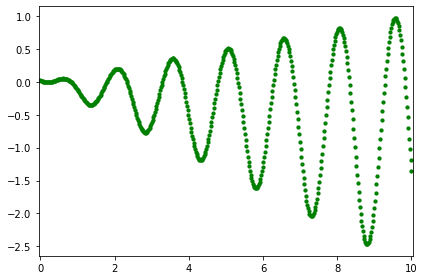

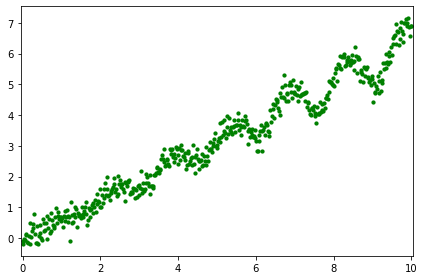

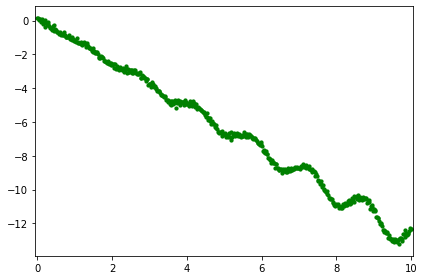

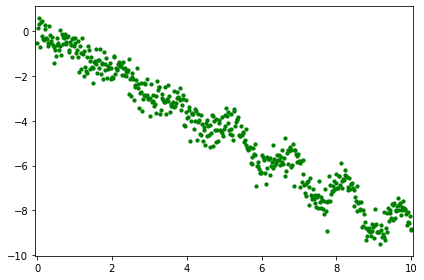

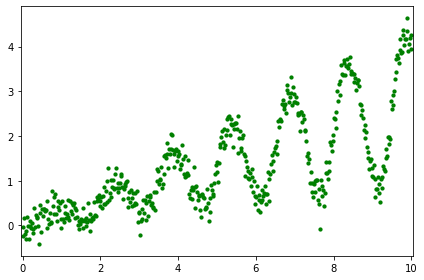

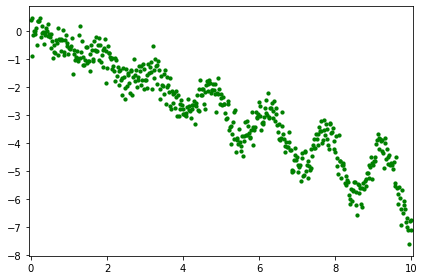

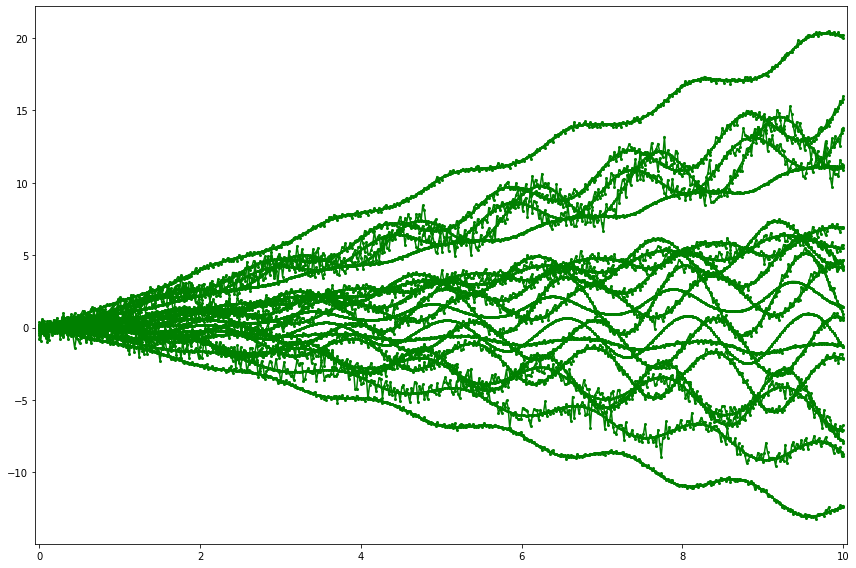

In [5]:
cov = Times(Linear(0.1), Periodic(50, 3))
M = cov.f_mat(xs)
N = 20
ys_list = []

np.random.seed(10)
for i in range(N):
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    ys_list.append(ys) 
    fig, ax = plt.subplots()
    epsilon = np.random.uniform(0, abs(.05*(max(ys) - min(ys))))
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(6,4)
    fig.set_tight_layout(True)
    figname = '/tmp/gp-per-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.plot(xs, ys, color='green', linewidth=1.5, marker='o', ms=2)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
figname = '/tmp/gp-per.png'
fig.savefig(figname, dpi=200)

for ys in ys_list:
    print(['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])

<ipython-input-6-1543d4cdec2d>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


['-0.52', '-0.54', '0.89', '0.82']
['-0.55', '-0.48', '0.80', '0.84']
['-0.00', '-0.26', '-1.33', '-1.32']
['0.00', '-0.25', '-1.42', '-1.05']
['0.01', '-0.15', '-0.22', '-0.23']
['0.01', '-0.15', '-0.22', '-0.23']
['-1.38', '-1.32', '-0.03', '0.00']
['-1.27', '-1.29', '0.00', '0.06']
['-4.27', '-4.28', '-1.49', '-1.51']
['-4.76', '-4.44', '-1.20', '-1.68']
['4.12', '4.09', '0.08', '0.07']
['4.64', '4.07', '-0.07', '-0.16']
['-1.74', '-1.58', '1.13', '1.15']
['-1.77', '-1.73', '1.13', '1.32']
['0.62', '0.65', '1.51', '1.50']
['0.57', '0.64', '1.55', '1.50']
['-0.87', '-0.64', '0.75', '0.75']
['-0.87', '-0.66', '0.75', '0.69']
['-0.07', '-0.06', '0.89', '0.89']
['-0.01', '-0.05', '0.91', '0.85']
['2.55', '2.59', '0.11', '0.11']
['2.44', '2.63', '0.10', '0.01']
['-0.24', '-0.45', '0.22', '0.24']
['-0.28', '-0.45', '0.25', '0.30']
['-1.95', '-1.68', '-0.72', '-0.75']
['-1.94', '-1.81', '-0.78', '-0.80']
['1.46', '1.73', '-0.73', '-0.74']
['1.40', '1.92', '-0.98', '-0.87']
['1.35', '1.54',

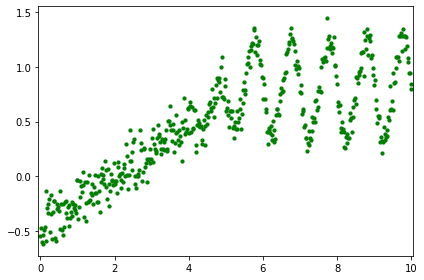

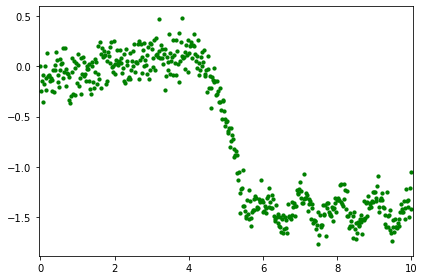

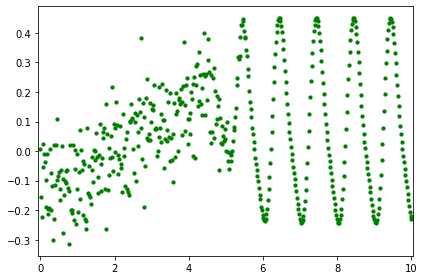

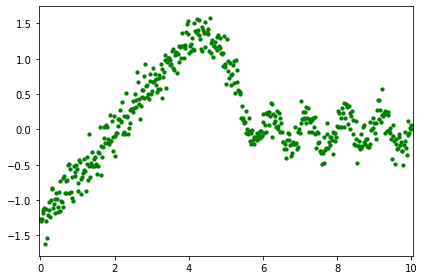

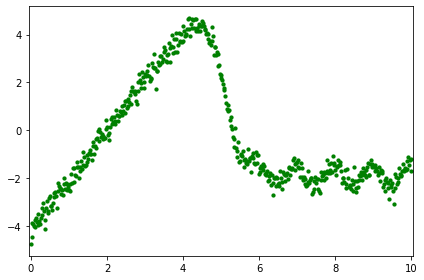

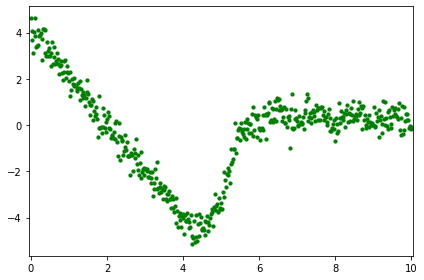

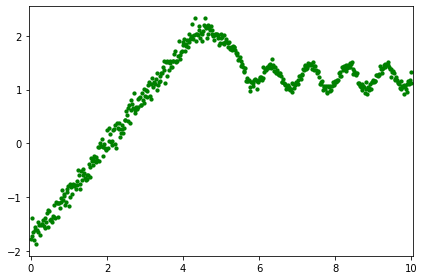

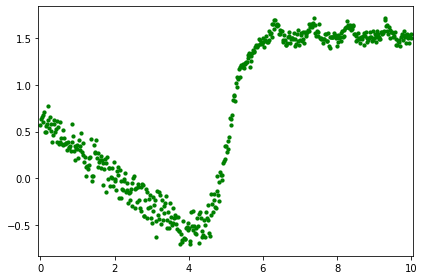

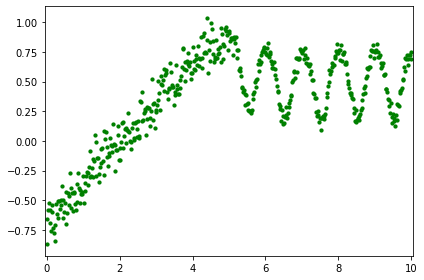

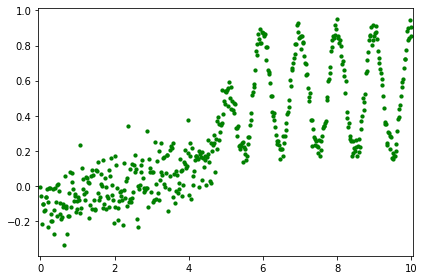

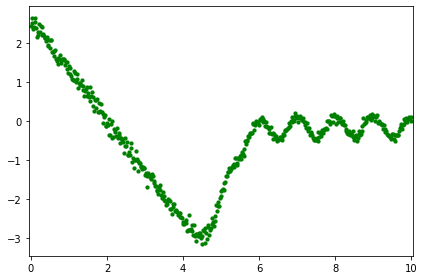

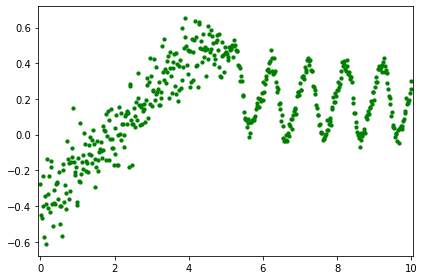

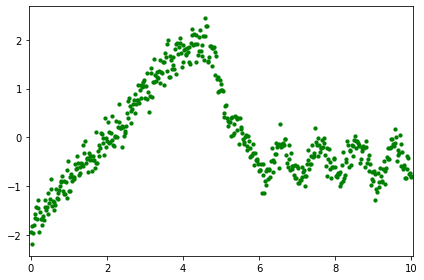

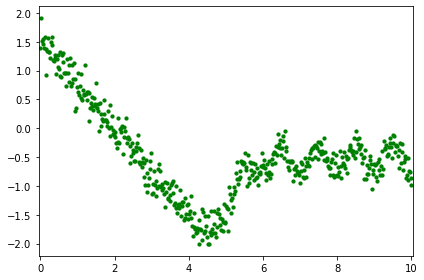

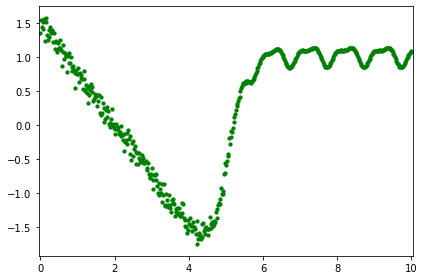

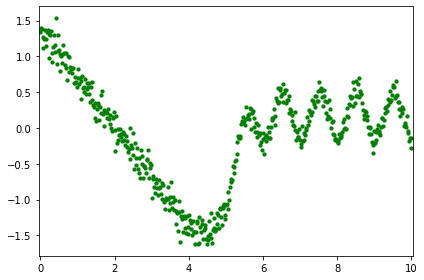

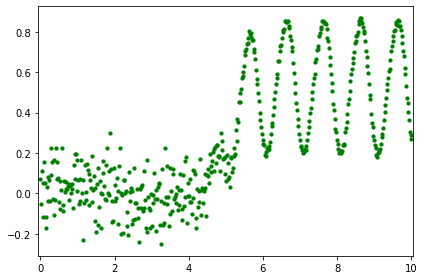

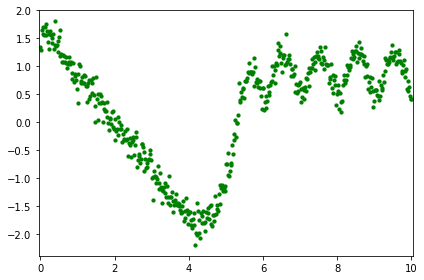

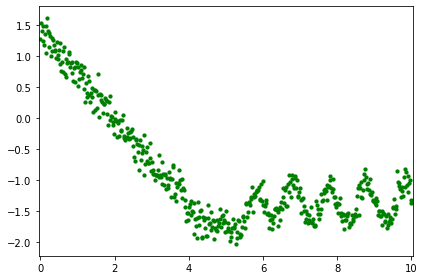

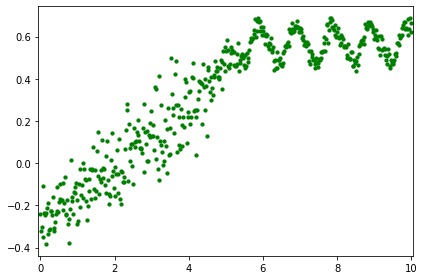

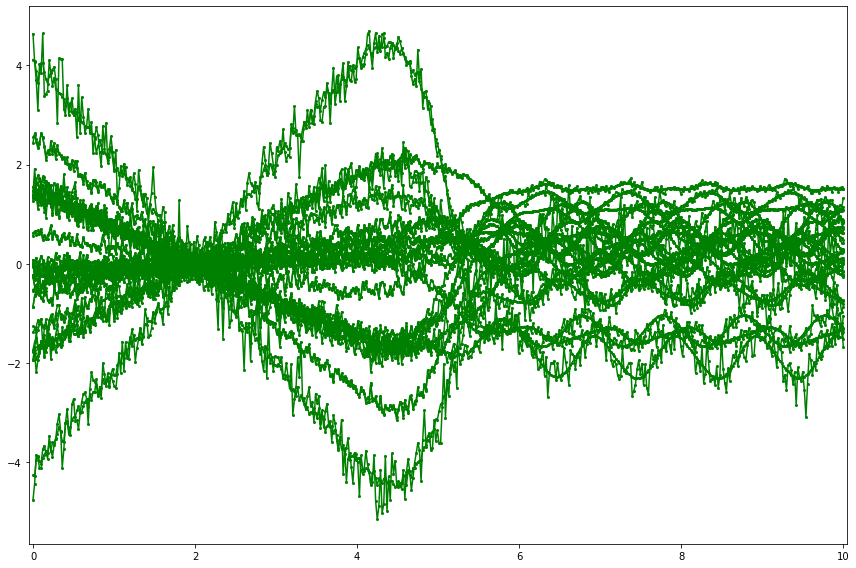

In [6]:
cov = ChangePoint(Plus(Linear(2), WhiteNoise(0.01)), Periodic(10, 2), 5, 0.5)
M = cov.f_mat(xs)
N = 20
ys_list = []

np.random.seed(110)
for i in range(N):
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    ys_list.append(ys)
    fig, ax = plt.subplots()
    epsilon = np.random.uniform(0, abs(.05*(max(ys) - min(ys))))
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(6, 4)
    figname = '/tmp/gp-cp-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.plot(xs, ys, color='green', linewidth=1.5, marker='o', ms=2)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
figname = '/tmp/gp-cp.png'
fig.savefig(figname, dpi=200)

for ys in ys_list:
    print(['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])

<ipython-input-7-ade2391d6697>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


['-1.12', '-1.12', '-1.33', '-1.33']
['-1.17', '-1.02', '-1.48', '-1.29']
['2.08', '2.08', '0.50', '0.50']
['2.10', '2.10', '0.30', '1.11']
['-0.10', '-0.10', '-0.34', '-0.34']
['-0.10', '-0.10', '-0.34', '-0.34']
['0.20', '0.20', '-2.51', '-2.52']
['0.44', '0.24', '-2.45', '-2.40']
['3.12', '3.12', '-7.18', '-7.22']
['1.97', '2.76', '-6.50', '-7.61']
['-0.89', '-0.89', '7.87', '7.91']
['0.26', '-0.94', '7.54', '7.39']
['-1.59', '-1.59', '-4.22', '-4.24']
['-1.67', '-1.96', '-4.22', '-3.83']
['-2.26', '-2.26', '0.32', '0.32']
['-2.38', '-2.29', '0.42', '0.31']
['-0.65', '-0.65', '-1.63', '-1.63']
['-0.66', '-0.69', '-1.62', '-1.75']
['-0.75', '-0.75', '-0.50', '-0.50']
['-0.67', '-0.74', '-0.48', '-0.56']
['-0.04', '-0.04', '5.20', '5.23']
['-0.27', '0.04', '5.17', '5.00']
['-0.23', '-0.23', '-0.96', '-0.96']
['-0.30', '-0.23', '-0.91', '-0.86']
['0.89', '0.89', '-3.28', '-3.30']
['0.89', '0.63', '-3.41', '-3.42']
['0.64', '0.64', '3.30', '3.32']
['0.50', '1.04', '2.75', '3.02']
['-1.6

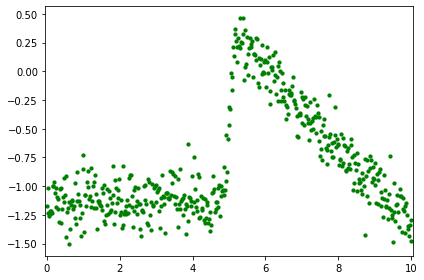

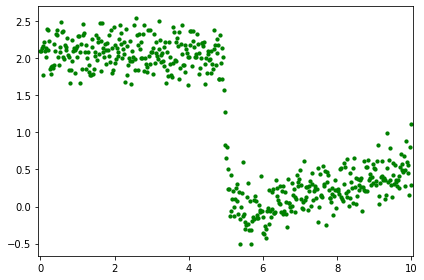

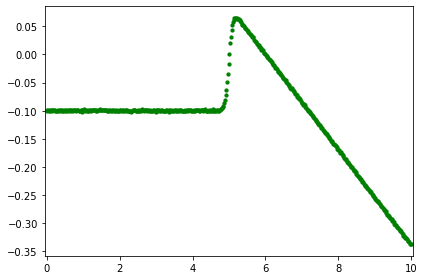

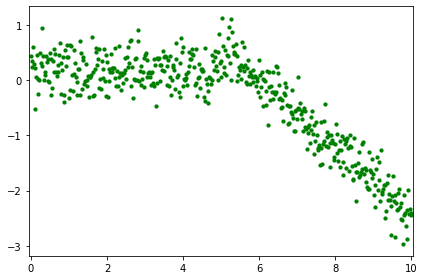

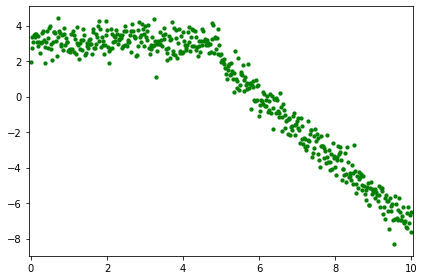

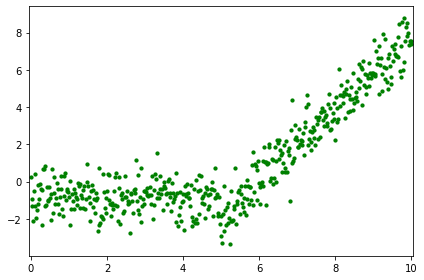

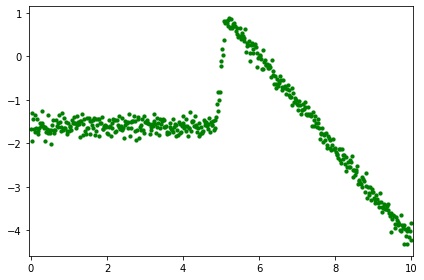

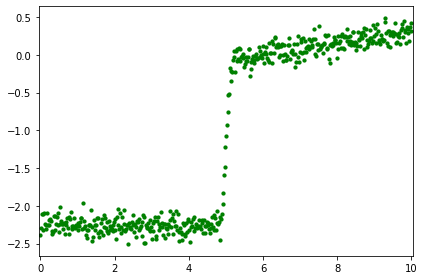

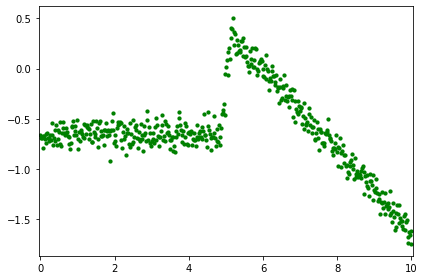

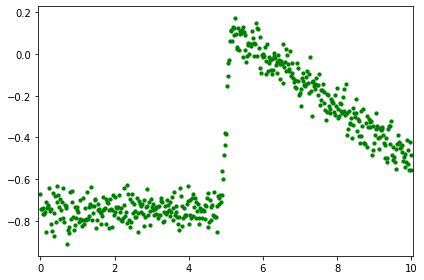

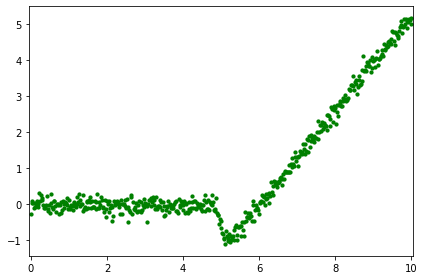

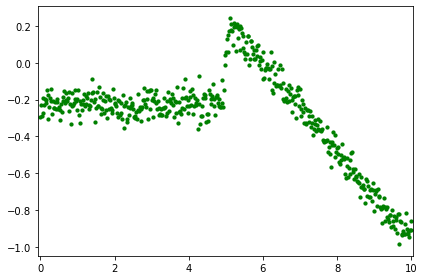

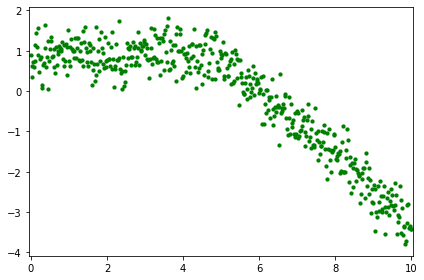

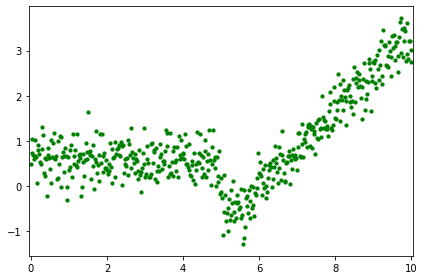

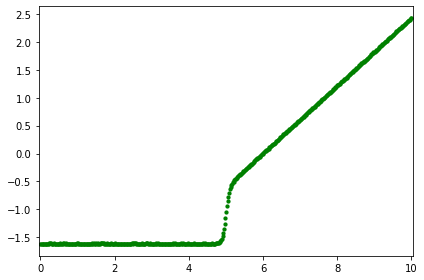

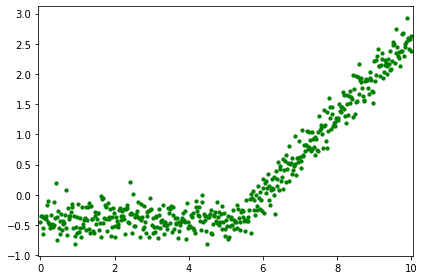

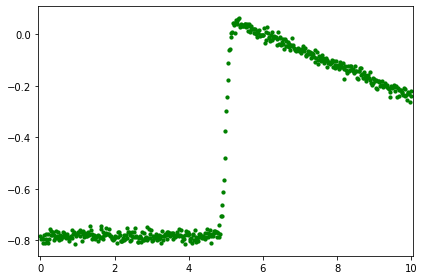

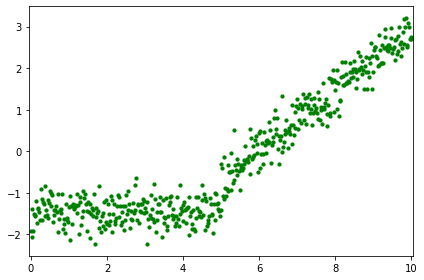

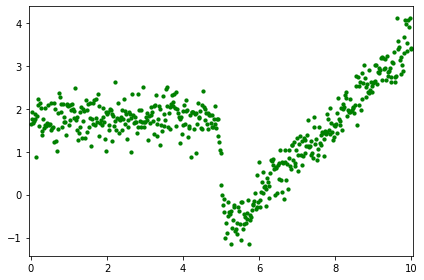

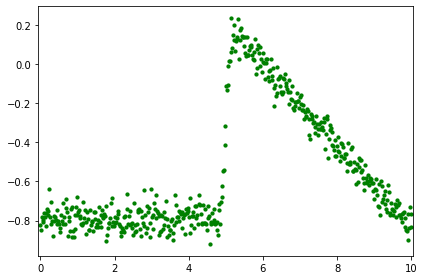

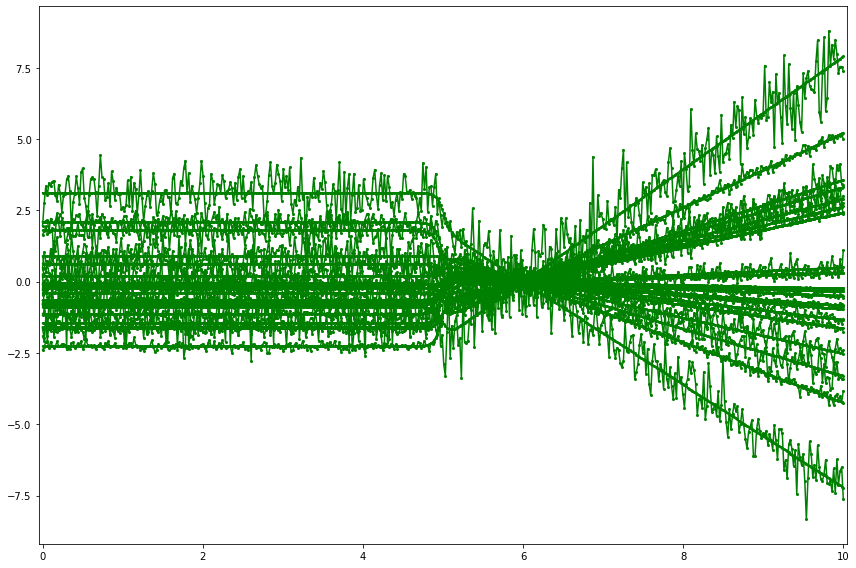

In [7]:
cov = ChangePoint(Constant(2), Linear(6), 5, 0.1)
M = cov.f_mat(xs)
N = 20
ys_list = []

np.random.seed(110)
for i in range(N):
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    ys_list.append(ys)
    fig, ax = plt.subplots()
    epsilon = np.random.uniform(0, abs(.1*(max(ys) - min(ys))))
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(6, 4)
    figname = '/tmp/gp-const-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.plot(xs, ys, color='green', linewidth=1.5, marker='o', ms=2)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
figname = '/tmp/gp-const.png'
fig.savefig(figname, dpi=200)

for ys in ys_list:
    print(['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])

0 0.2854383917302204
1 0.11122508981964015
2 0.0018182952500448413
3 0.5887864753427777
4 0.9368417391203437
5 1.7082740927657647
6 0.28202664633337826
7 0.0322947210943667
8 0.176536013562643
9 0.08087799639592878
10 0.28858465611703266
11 0.10828395795800207
12 0.6839054918310312
13 0.6497689073721108
14 0.006896910204306427
15 0.35739863707895636
16 0.008518727452482819
17 0.5331903415278479
18 0.6416817671898667
19 0.10418024715847977


<ipython-input-8-dc72df5b9987>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


0 ['-0.33', '-0.32', '2.95', '2.96']
1 ['-0.43', '-0.10', '2.63', '3.04']
2 ['0.12', '0.11', '-1.05', '-1.05']
3 ['0.12', '0.13', '-1.16', '-0.73']
4 ['-0.08', '-0.08', '0.76', '0.76']
5 ['-0.09', '-0.08', '0.76', '0.76']
6 ['-0.63', '-0.62', '5.66', '5.68']
7 ['-0.13', '-0.52', '5.79', '5.91']
8 ['-1.82', '-1.78', '16.32', '16.36']
9 ['-3.84', '-2.42', '17.52', '15.68']
10 ['1.98', '1.94', '-17.78', '-17.82']
11 ['4.36', '1.84', '-18.45', '-18.88']
12 ['-1.05', '-1.03', '9.46', '9.48']
13 ['-1.23', '-1.81', '9.45', '10.33']
14 ['0.09', '0.09', '-0.81', '-0.81']
15 ['0.05', '0.08', '-0.78', '-0.81']
16 ['-0.41', '-0.40', '3.64', '3.65']
17 ['-0.43', '-0.48', '3.65', '3.41']
18 ['-0.12', '-0.12', '1.10', '1.11']
19 ['-0.00', '-0.11', '1.13', '1.03']
20 ['1.31', '1.28', '-11.73', '-11.76']
21 ['0.82', '1.44', '-11.79', '-12.23']
22 ['-0.24', '-0.24', '2.16', '2.16']
23 ['-0.38', '-0.23', '2.27', '2.38']
24 ['-0.83', '-0.81', '7.44', '7.46']
25 ['-0.82', '-1.34', '7.20', '7.23']
26 ['0.83

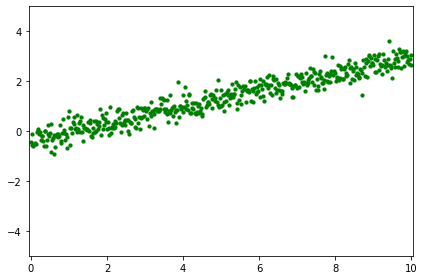

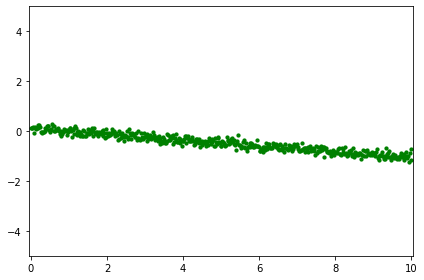

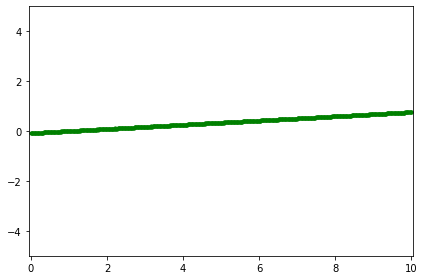

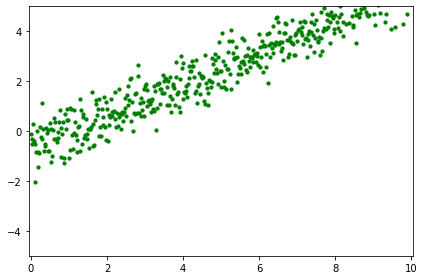

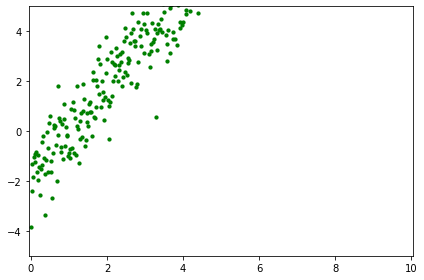

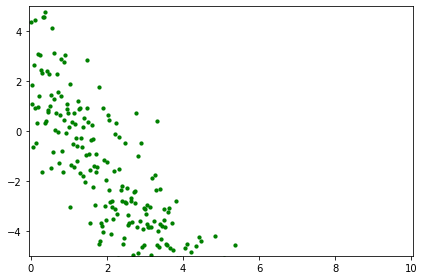

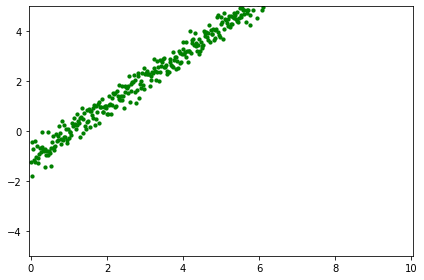

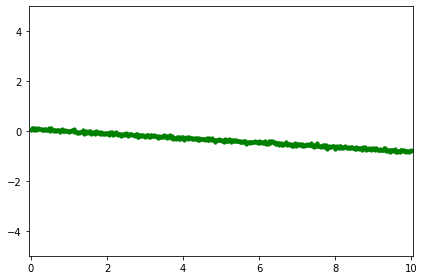

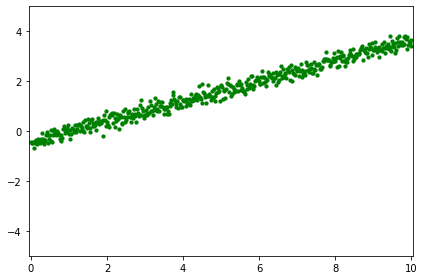

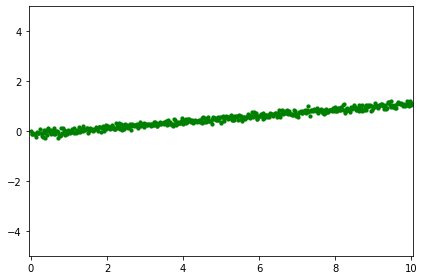

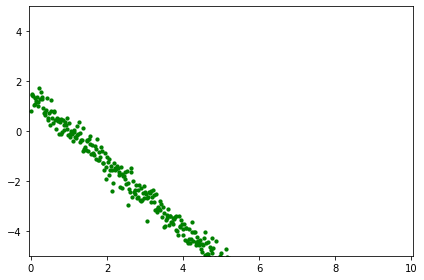

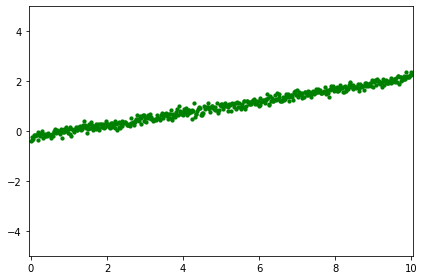

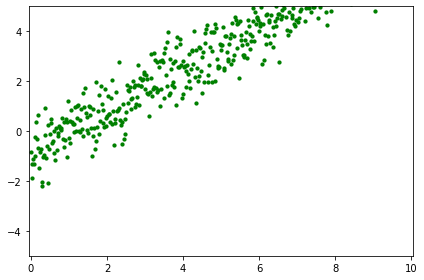

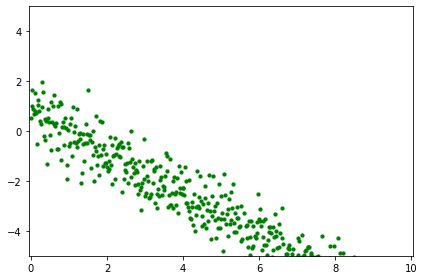

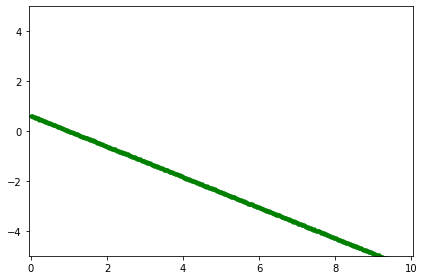

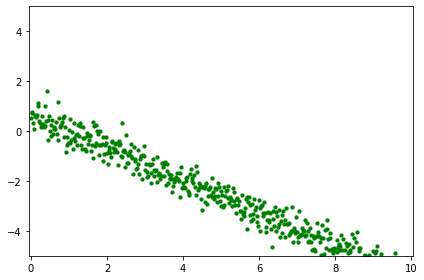

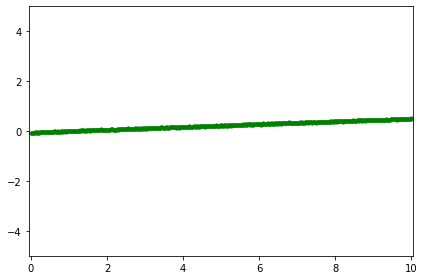

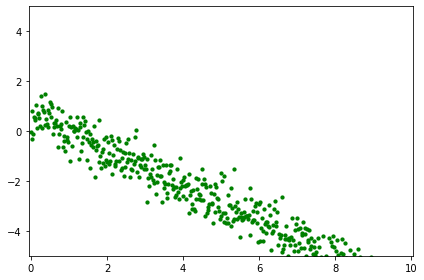

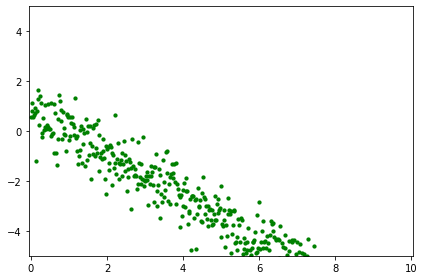

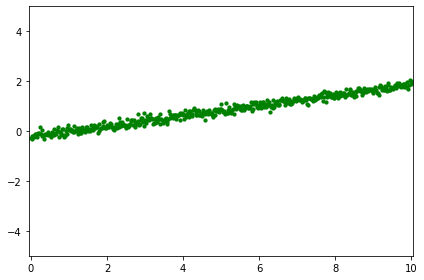

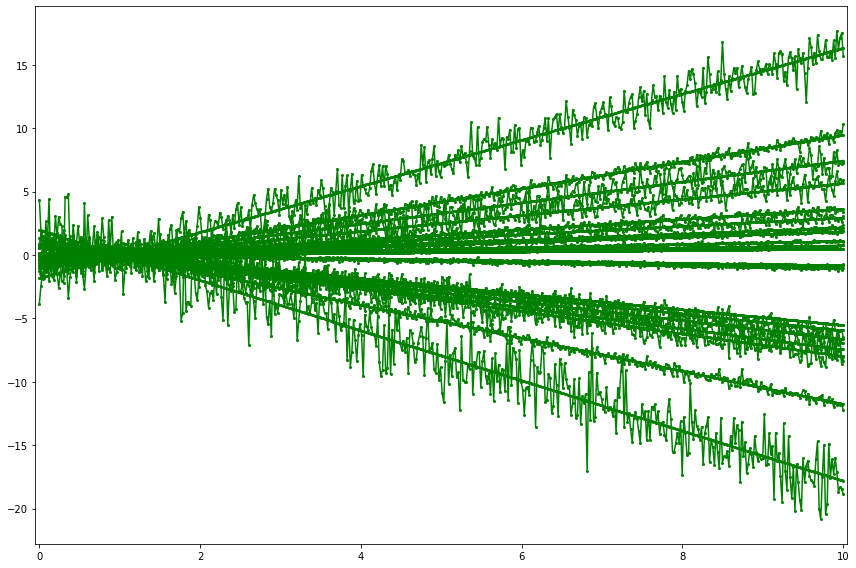

In [8]:
cov = Linear(1)
M = cov.f_mat(xs)
N = 20
ys_list = []

np.random.seed(110)
for i in range(N):
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    ys_list.append(ys)
    fig, ax = plt.subplots()
    epsilon = np.random.uniform(0, abs(.1*(max(ys) - min(ys))))
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    ax.set_ylim([-5, 5])
    fig.set_tight_layout(True)
    fig.set_size_inches(6, 4)
    figname = '/tmp/gp-lin-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    print(i, epsilon)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.plot(xs, ys, color='green', linewidth=1.5, marker='o', ms=2)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
figname = '/tmp/gp-lin.png'
fig.savefig(figname, dpi=200)

for i, ys in enumerate(ys_list):
    print(i, ['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])